# "A" sessile drop sitting on a superhydrophobic surface

<img src="Schematic.png" 
        alt="Picture" 
        width="600" 
        style="display: block; margin: 0 auto" />

Laplace equaiton for this problem gives a boundary value problem (see figure) where the two boundaries are the surface of the drop and the surface of the substrate. However, both boundaries are not known apriori. Therefore, we will solve the problem using the initial value problem (IVP) formulation.

The set of ODE that we need to solve is the following:

$$ \frac{d\phi}{ds} + \frac{\sin\phi}{r} = \kappa_T + Bo z $$

where $r-z$ is the cylindrical coordinate system as shown in the figure. We have parameterized the equation for curvature using the length of arc $s$ and the tangent angle $\phi$. See page 15-16 of [deserno2004notes](https://www.cmu.edu/biolphys/deserno/pdf/diff_geom.pdf) for more details. Consequently, two more ODEs are needed to solve the problem:

$$ \frac{dr}{ds} = \cos\phi $$
$$ \frac{dz}{ds} = \sin\phi $$

### Initial conditions

$$ \phi(s = 0) = 0 $$
$$ r(s = 0) = 0 $$ 

**Note:** Need to initialize with a very small (finite) valuen of $r(s = 0)$ to avoid division by zero.

$$ z(s = 0) = 0 $$

### References
``` bib
@misc{deserno2004notes,
  title={Notes on differential geometry},
  author={Deserno, M.},
  year={2004},
  publisher={Dover, New York. https://www.cmu.edu/biolphys/deserno/pdf/diff_geom.pdf}
}
```

*Note* Initial guess of $\kappa_T$: The initial guess for the curvature at the apex of the drop is taken from the database: [NormalizeBond.csv](NormalizeBond.csv). If such a file is absent, $\kappa_T = 2$ is taken as the initial guess. 

### Essential imports

In [1]:
from numpy import *
from scipy.integrate import solve_ivp
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
import os
import pandas as pd
import sys

mpl.rcParams['text.usetex'] = True
mpl.rcParams['font.family'] = 'serif'

AxesLabel, TickLabel = [30, 30]
plt.rcParams.update({
    'font.size' : TickLabel,                   # Set font size to 11pt
    'axes.labelsize': AxesLabel,               # -> axis labels
    'legend.fontsize': AxesLabel,              # -> legends
    'xtick.labelsize': TickLabel,              # -> x-axis tick labels
    'ytick.labelsize': TickLabel,              # -> y-axis tick labels
})


## Essential functions

### Solution

In [2]:
# Laplace equation for a sessile drop
def LaplaceEqn(t, y, Bo, KappaT):
    Phi = y[0]
    r = y[1]
    z = y[2]

    f0 = Bo*z + KappaT - sin(Phi)/r
    f1 = cos(Phi)
    f2 = sin(Phi)

    return array([f0, f1, f2])

# stop integration when Phi = pi
def event(t, y, Bo, KappaT):
    return y[0] - 1.001*pi

# calculate the volume of the drop given by (R, Z)
def volume(R, Z):
    return -pi*trapz(R**2, Z)

# calculate the volume of the drop given by (R, Z)
def surface(R, Z, S):
    return 2*pi*trapz(R, S)

# calculate the center of mass of the drop given by (R, Z)
def centerOfMass(R, Z):
    return trapz((R**2)*Z, Z)/trapz(R**2, Z)

# main funtion to get the drop shape
def getDrop(Bo, KappaT):
  # Initial conditions
  Phi0, r0, z0 = 0.0, 1e-50, 0.0
  y0 = array([Phi0, r0, z0])
  y0.reshape(3,)

  # parameterizatio is done using the arc length s
  s0, sMax, ds = 0.0, 5*pi, 1e-6
  
  event.terminal = True
  return solve_ivp(LaplaceEqn, [s0, sMax], y0, args=(Bo, KappaT), t_eval=arange(s0, sMax, ds), events=event, rtol=1e-10, atol=1e-16)


### Gradient descent algorithm to get the drop profile!

In [3]:
def CorrectDrop(Bo, CountMax, lr, KappaT):
      Error, VolError = [], 1.0
      count = 0
      while (abs(VolError) > 1.0e-10 and count < CountMax):
        print('------------------------------------')
        count += 1
        sol = getDrop(Bo, KappaT)
        S, Phi, r, z = sol.t, sol.y[0], sol.y[1], sol.y[2]
        # coordinate transformation to have drop straight up
        Z = -z+z[-1]
        R = r
        # join a straight line from the last point to the origin
        Z = append(Z, 0.0)
        R = append(R, 0.0)
        S = append(S, S[-1]+r[-1])
        r = append(r, 0.0)
        z = append(z, z[-1])
        Phi = append(Phi, pi)

        Vol = volume(R, Z)
        VolError = Vol - (4.0/3.0)*pi
        print('Volume = %4.3e and VolError = %4.3e' % (Vol, VolError))

        # use gradient descent to find the updated KappaT
        if KappaT < 1:
          KappaT = KappaT*(1.0 + lr*VolError)
        else:
          KappaT = KappaT + lr*VolError
        
        print('Done: Iteration = %d, Next KappaT = %5.4e' % (count, KappaT))
        Error.append(VolError)
        KappaTNew = KappaT

      print('------------------------------------')

      # if the volume did not converge, stop the code
      if abs(VolError) > 1.0e-6:
          print('Volume did not converge after %d iterations for Bond = %.15e. Stopping code. VolError = %4.3e' % (count, Bo, VolError))
          sys.exit(1)
      
      return R, Z, S, Phi, r, z, KappaTNew, Error

### Function to run Basilisk to check the initial condition

In [4]:
def gettingFacets(L0, InitConditionFile):
    import subprocess as sp
    exe = ["./InitialCondition", str(L0), InitConditionFile]
    p = sp.Popen(exe, stdout=sp.PIPE, stderr=sp.PIPE)
    stdout, stderr = p.communicate()
    temp1 = stderr.decode("utf-8")
    temp2 = temp1.split("\n")
    segs = []
    skip = False
    if (len(temp2) > 1e2):
        for n1 in range(len(temp2)):
            temp3 = temp2[n1].split(" ")
            if temp3 == ['']:
                skip = False
                pass
            else:
                if not skip:
                    temp4 = temp2[n1+1].split(" ")
                    r1, z1 = array([float(temp3[1]), float(temp3[0])])
                    r2, z2 = array([float(temp4[1]), float(temp4[0])])
                    segs.append(((r1, z1),(r2,z2)))
                    skip = True
    return segs

### Plotting

In [5]:
def Plotting(R, Z, S, Phi, r, z, filename, Bo, KappaT, Zcm, InterfaceBas, TestWithBasilisk):
    S = S/pi

    fig, AX = plt.subplots(2, 2)
    fig.patch.set_facecolor('white')
    fig.set_size_inches(20, 15)
    ax1, ax2, ax3, ax4 = AX.flatten()

    
    ax1.plot(R, Z, 'r-', linewidth=4.0)
    ax1.plot(-R, Z, 'r-', linewidth=4.0)
    if TestWithBasilisk:
        line_segments = LineCollection(InterfaceBas, linewidths=4, colors='#1a9641', linestyle='solid')
        ax1.add_collection(line_segments)

    ax1.plot(0, Zcm, 'bo', markersize=15.0)
    ax1.set_xlabel(r'$\mathcal{R}/R_0$')
    ax1.set_ylabel(r'$\mathcal{Z}/R_0$')
    if Bo<125:
        ax1.set_aspect('equal')
    else:
        ax1.set_box_aspect(1)
    ax1.set_xlim(-1.1*R.max(), 1.1*R.max())
    ax1.set_ylim(0.0, 1.05*Z.max())

    ax2.plot(S, Phi/pi, 'b-', linewidth=4.0)
    ax2.set_xlabel(r'$s/\left(\pi R_0\right)$')
    ax2.set_ylabel(r'$\phi/\pi$')
    ax2.set_box_aspect(1)
    ax2.set_xlim(0.0, S.max())
    ax2.set_ylim(0.0, 1.05)

    ax3.plot(S, r, 'k-')
    ax3.set_xlabel(r'$s/\left(\pi R_0\right)$')
    ax3.set_ylabel(r'$r/R_0$')
    ax3.set_box_aspect(1)
    ax3.set_xlim(0.0, S.max())
    ax3.set_ylim(0.0, 1.05*r.max())

    ax4.plot(S, z, 'k-')
    ax4.set_xlabel(r'$s/\left(\pi R_0\right)$')
    ax4.set_ylabel(r'$z/R_0$')
    ax4.set_box_aspect(1)
    ax4.set_xlim(0.0, S.max())
    ax4.set_ylim(0.0, 1.05*z.max())
    # set figure title
    l1, b1, w1, h1 = ax1.get_position().bounds
    l2, b2, w2, h2 = ax2.get_position().bounds

    L = max(b1+h1, b2+h2)
    # set title position
    fig.text(0.5, L+0.025, r'$Bo = %5.4e$, $\kappa_TR_0 = %5.4e$' % (Bo, KappaT), fontsize=AxesLabel, ha='center')

    plt.savefig(filename, bbox_inches='tight')
    plt.show()

## Main code

Initial guess for KappaT =  2.0006880225931503
------------------------------------
Volume = 4.180e+00 and VolError = -8.496e-03
Done: Iteration = 1, Next KappaT = 1.9986e+00
------------------------------------
Volume = 4.194e+00 and VolError = 4.837e-03
Done: Iteration = 2, Next KappaT = 1.9998e+00
------------------------------------
Volume = 4.186e+00 and VolError = -2.761e-03
Done: Iteration = 3, Next KappaT = 1.9991e+00
------------------------------------
Volume = 4.190e+00 and VolError = 1.574e-03
Done: Iteration = 4, Next KappaT = 1.9995e+00
------------------------------------
Volume = 4.188e+00 and VolError = -8.977e-04
Done: Iteration = 5, Next KappaT = 1.9993e+00
------------------------------------
Volume = 4.189e+00 and VolError = 5.119e-04
Done: Iteration = 6, Next KappaT = 1.9994e+00
------------------------------------
Volume = 4.188e+00 and VolError = -2.919e-04
Done: Iteration = 7, Next KappaT = 1.9993e+00
------------------------------------
Volume = 4.189e+00 and 

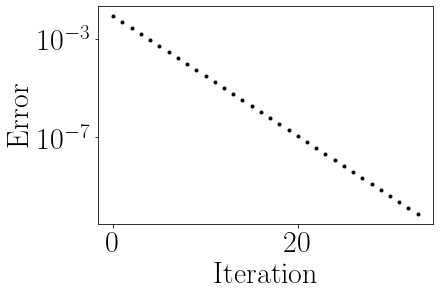

------------------------------------
(3V)(4pi)^{-1} = 1.0000e+00
Perimeter = 3.1411e+00
Surface Area = 1.2566e+01
KappaT = 1.9993e+00, Bo = 1.0000e-03, H = 1.997, Zcm = 0.997, W = 1.000, Rw = 0.024
<------------------------------------>
Doing Basilisk now for Bo = 1.0000e-03
Done with Basilisk for Bo = 1.0000e-03


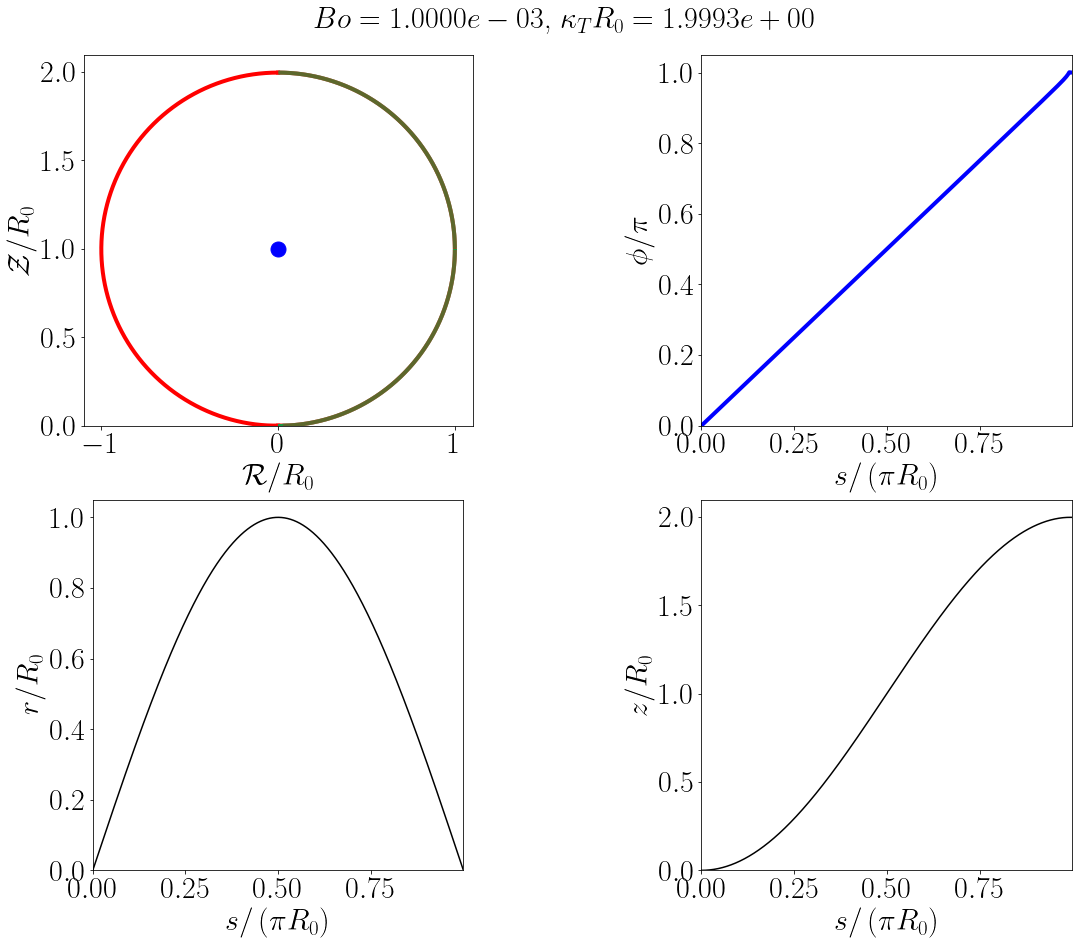

Initial guess for KappaT =  1.9947031285889003
------------------------------------
Volume = 4.180e+00 and VolError = -8.430e-03
Done: Iteration = 1, Next KappaT = 1.9926e+00
------------------------------------
Volume = 4.194e+00 and VolError = 4.760e-03
Done: Iteration = 2, Next KappaT = 1.9938e+00
------------------------------------
Volume = 4.186e+00 and VolError = -2.695e-03
Done: Iteration = 3, Next KappaT = 1.9931e+00
------------------------------------
Volume = 4.190e+00 and VolError = 1.524e-03
Done: Iteration = 4, Next KappaT = 1.9935e+00
------------------------------------
Volume = 4.188e+00 and VolError = -8.621e-04
Done: Iteration = 5, Next KappaT = 1.9933e+00
------------------------------------
Volume = 4.189e+00 and VolError = 4.875e-04
Done: Iteration = 6, Next KappaT = 1.9934e+00
------------------------------------
Volume = 4.189e+00 and VolError = -2.758e-04
Done: Iteration = 7, Next KappaT = 1.9933e+00
------------------------------------
Volume = 4.189e+00 and 

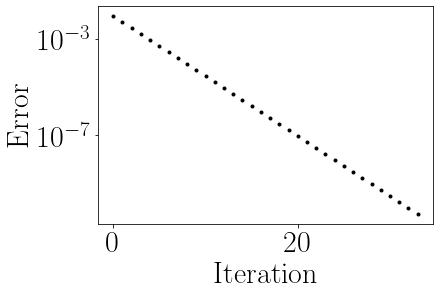

------------------------------------
(3V)(4pi)^{-1} = 1.0000e+00
Perimeter = 3.1371e+00
Surface Area = 1.2567e+01
KappaT = 1.9934e+00, Bo = 1.0000e-02, H = 1.979, Zcm = 0.982, W = 1.002, Rw = 0.080
<------------------------------------>
Doing Basilisk now for Bo = 1.0000e-02
Done with Basilisk for Bo = 1.0000e-02


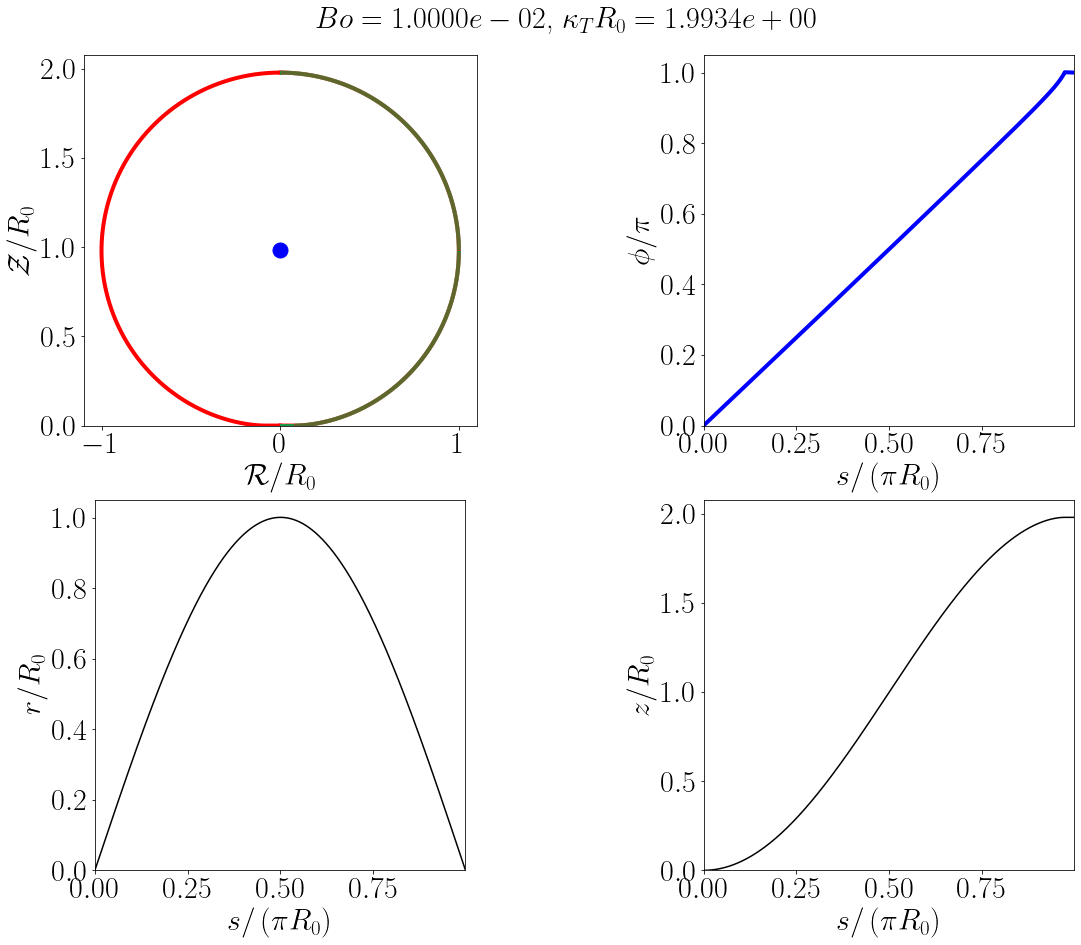

Initial guess for KappaT =  1.937283687145742
------------------------------------
Volume = 4.177e+00 and VolError = -1.176e-02
Done: Iteration = 1, Next KappaT = 1.9343e+00
------------------------------------
Volume = 4.195e+00 and VolError = 6.149e-03
Done: Iteration = 2, Next KappaT = 1.9359e+00
------------------------------------
Volume = 4.186e+00 and VolError = -3.229e-03
Done: Iteration = 3, Next KappaT = 1.9351e+00
------------------------------------
Volume = 4.190e+00 and VolError = 1.692e-03
Done: Iteration = 4, Next KappaT = 1.9355e+00
------------------------------------
Volume = 4.188e+00 and VolError = -8.875e-04
Done: Iteration = 5, Next KappaT = 1.9353e+00
------------------------------------
Volume = 4.189e+00 and VolError = 4.653e-04
Done: Iteration = 6, Next KappaT = 1.9354e+00
------------------------------------
Volume = 4.189e+00 and VolError = -2.440e-04
Done: Iteration = 7, Next KappaT = 1.9353e+00
------------------------------------
Volume = 4.189e+00 and V

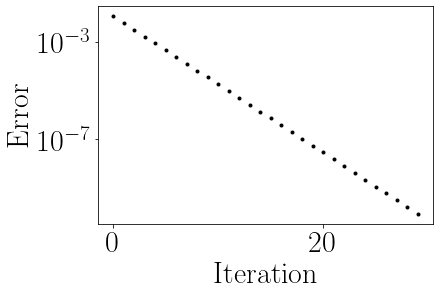

------------------------------------
(3V)(4pi)^{-1} = 1.0000e+00
Perimeter = 3.1097e+00
Surface Area = 1.2585e+01
KappaT = 1.9354e+00, Bo = 1.0000e-01, H = 1.869, Zcm = 0.895, W = 1.016, Rw = 0.249
<------------------------------------>
Doing Basilisk now for Bo = 1.0000e-01
Done with Basilisk for Bo = 1.0000e-01


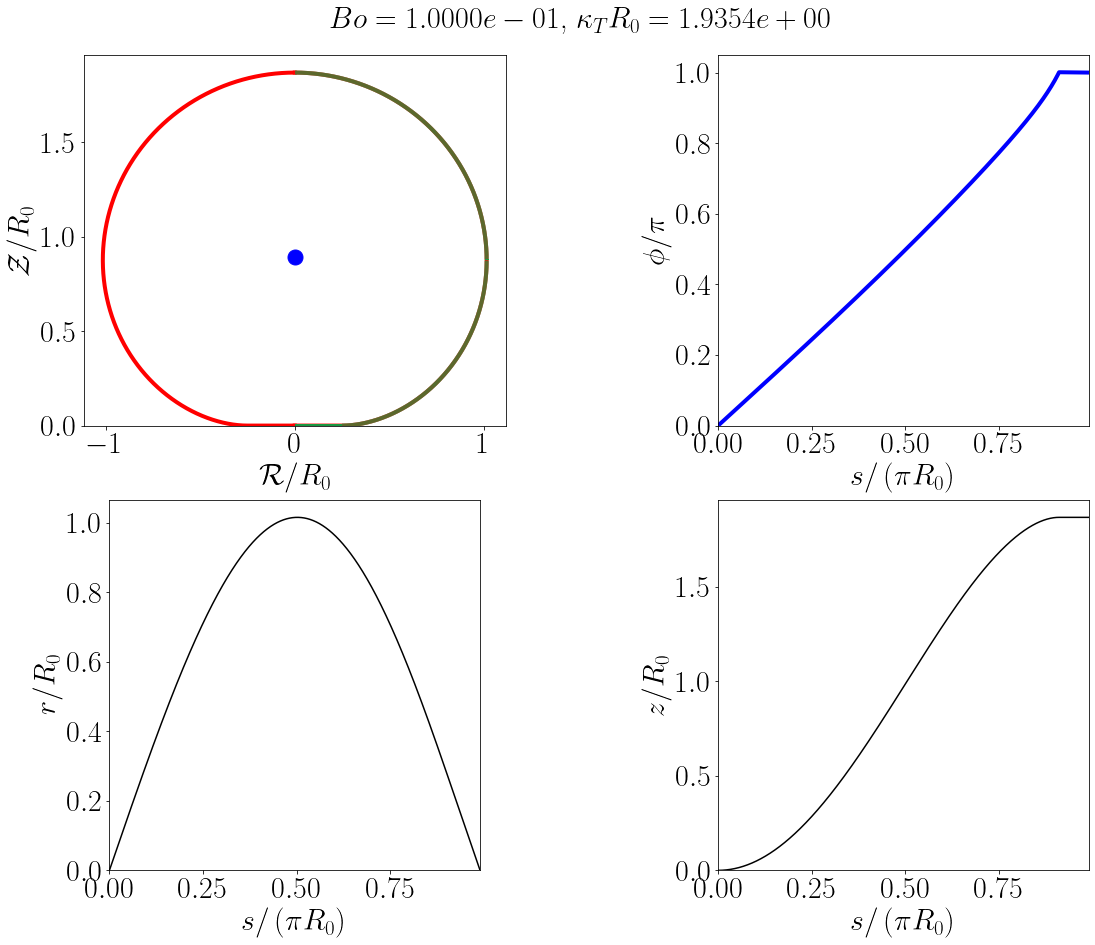

Initial guess for KappaT =  1.4738400842449897
------------------------------------
Volume = 4.171e+00 and VolError = -1.779e-02
Done: Iteration = 1, Next KappaT = 1.4694e+00
------------------------------------
Volume = 4.195e+00 and VolError = 6.116e-03
Done: Iteration = 2, Next KappaT = 1.4709e+00
------------------------------------
Volume = 4.187e+00 and VolError = -2.122e-03
Done: Iteration = 3, Next KappaT = 1.4704e+00
------------------------------------
Volume = 4.190e+00 and VolError = 7.340e-04
Done: Iteration = 4, Next KappaT = 1.4706e+00
------------------------------------
Volume = 4.189e+00 and VolError = -2.542e-04
Done: Iteration = 5, Next KappaT = 1.4705e+00
------------------------------------
Volume = 4.189e+00 and VolError = 8.798e-05
Done: Iteration = 6, Next KappaT = 1.4705e+00
------------------------------------
Volume = 4.189e+00 and VolError = -3.045e-05
Done: Iteration = 7, Next KappaT = 1.4705e+00
------------------------------------
Volume = 4.189e+00 and 

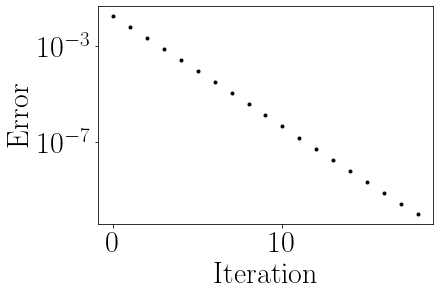

------------------------------------
(3V)(4pi)^{-1} = 1.0000e+00
Perimeter = 3.0493e+00
Surface Area = 1.3078e+01
KappaT = 1.4705e+00, Bo = 1.0000e+00, H = 1.447, Zcm = 0.627, W = 1.124, Rw = 0.675
<------------------------------------>
Doing Basilisk now for Bo = 1.0000e+00
Done with Basilisk for Bo = 1.0000e+00


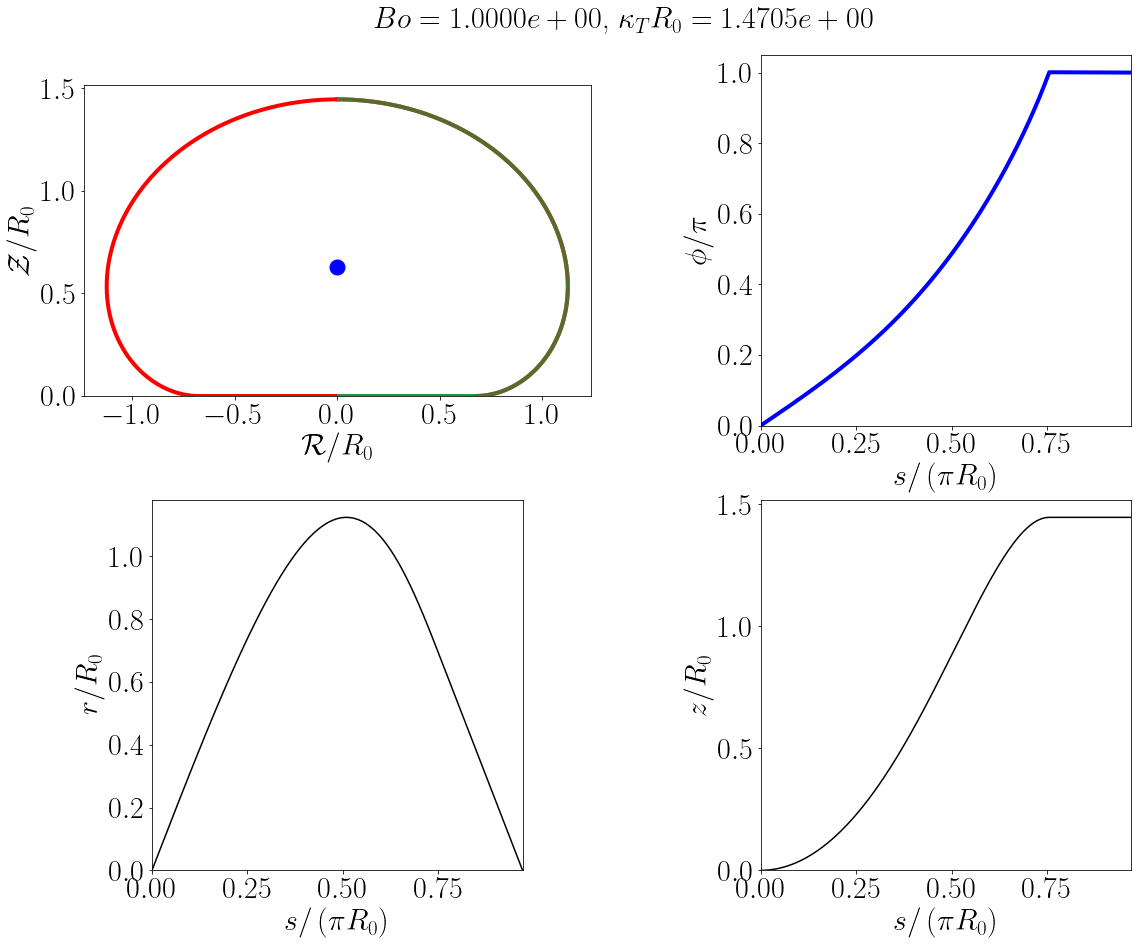

Initial guess for KappaT =  0.1232047737479391
------------------------------------
Volume = 4.196e+00 and VolError = 7.323e-03
Done: Iteration = 1, Next KappaT = 1.2343e-01
------------------------------------
Volume = 4.192e+00 and VolError = 3.691e-03
Done: Iteration = 2, Next KappaT = 1.2354e-01
------------------------------------
Volume = 4.191e+00 and VolError = 1.860e-03
Done: Iteration = 3, Next KappaT = 1.2360e-01
------------------------------------
Volume = 4.190e+00 and VolError = 9.371e-04
Done: Iteration = 4, Next KappaT = 1.2363e-01
------------------------------------
Volume = 4.189e+00 and VolError = 4.722e-04
Done: Iteration = 5, Next KappaT = 1.2365e-01
------------------------------------
Volume = 4.189e+00 and VolError = 2.379e-04
Done: Iteration = 6, Next KappaT = 1.2365e-01
------------------------------------
Volume = 4.189e+00 and VolError = 1.199e-04
Done: Iteration = 7, Next KappaT = 1.2366e-01
------------------------------------
Volume = 4.189e+00 and VolE

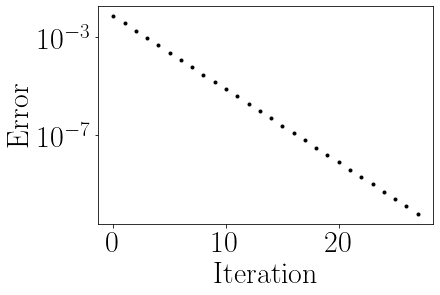

------------------------------------
(3V)(4pi)^{-1} = 1.0000e+00
Perimeter = 3.4458e+00
Surface Area = 1.8377e+01
KappaT = 1.2366e-01, Bo = 1.0000e+01, H = 0.666, Zcm = 0.290, W = 1.567, Rw = 1.401
<------------------------------------>
Doing Basilisk now for Bo = 1.0000e+01
Done with Basilisk for Bo = 1.0000e+01


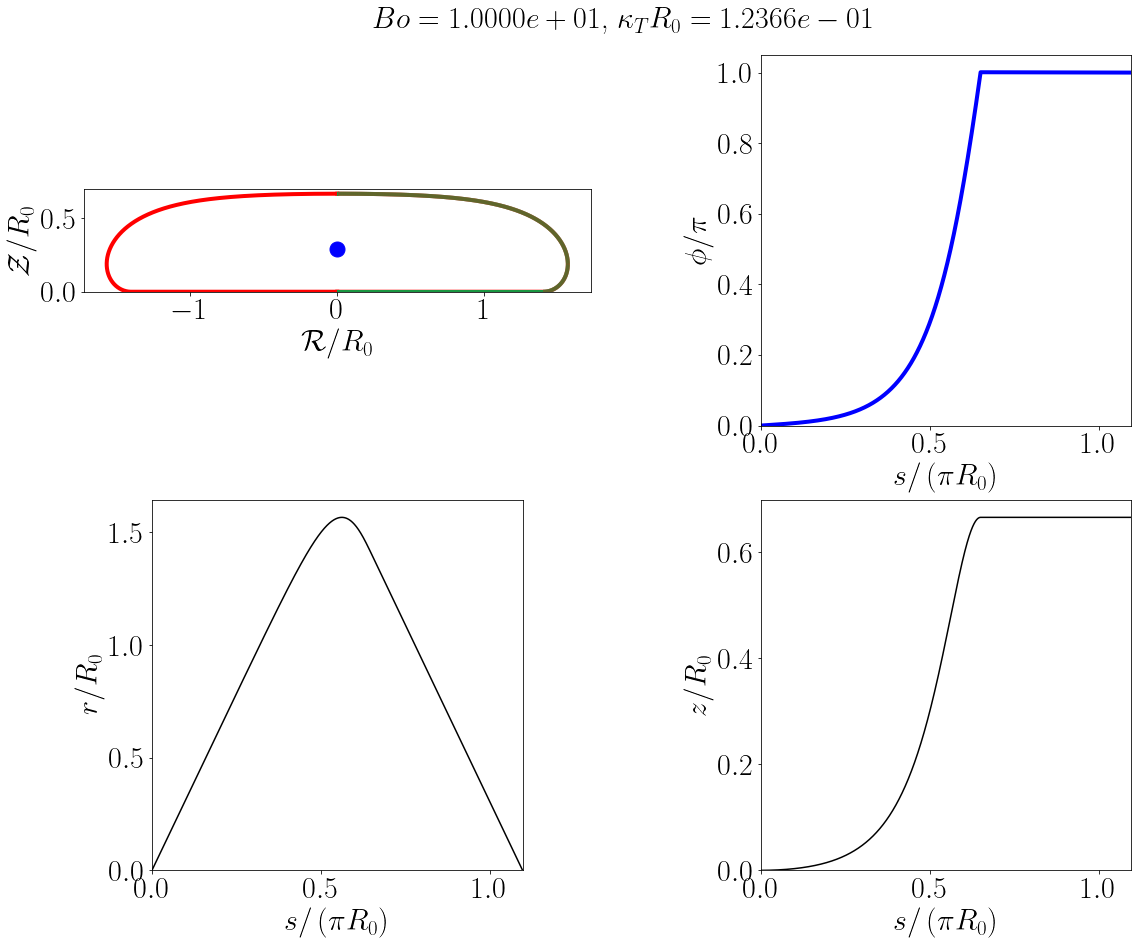

Initial guess for KappaT =  1.0357494187207507e-09
------------------------------------
Volume = 3.957e+00 and VolError = -2.322e-01
Done: Iteration = 1, Next KappaT = 9.7562e-10
------------------------------------
Volume = 3.976e+00 and VolError = -2.130e-01
Done: Iteration = 2, Next KappaT = 9.2367e-10
------------------------------------
Volume = 3.993e+00 and VolError = -1.953e-01
Done: Iteration = 3, Next KappaT = 8.7857e-10
------------------------------------
Volume = 4.010e+00 and VolError = -1.791e-01
Done: Iteration = 4, Next KappaT = 8.3923e-10
------------------------------------
Volume = 4.024e+00 and VolError = -1.643e-01
Done: Iteration = 5, Next KappaT = 8.0476e-10
------------------------------------
Volume = 4.038e+00 and VolError = -1.507e-01
Done: Iteration = 6, Next KappaT = 7.7444e-10
------------------------------------
Volume = 4.051e+00 and VolError = -1.382e-01
Done: Iteration = 7, Next KappaT = 7.4768e-10
------------------------------------
Volume = 4.062e+

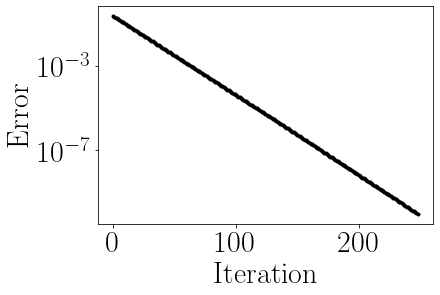

------------------------------------
(3V)(4pi)^{-1} = 1.0000e+00
Perimeter = 5.3317e+00
Surface Area = 4.4629e+01
KappaT = 5.0809e-10, Bo = 1.0000e+02, H = 0.203, Zcm = 0.099, W = 2.619, Rw = 2.565
<------------------------------------>
Doing Basilisk now for Bo = 1.0000e+02
Done with Basilisk for Bo = 1.0000e+02


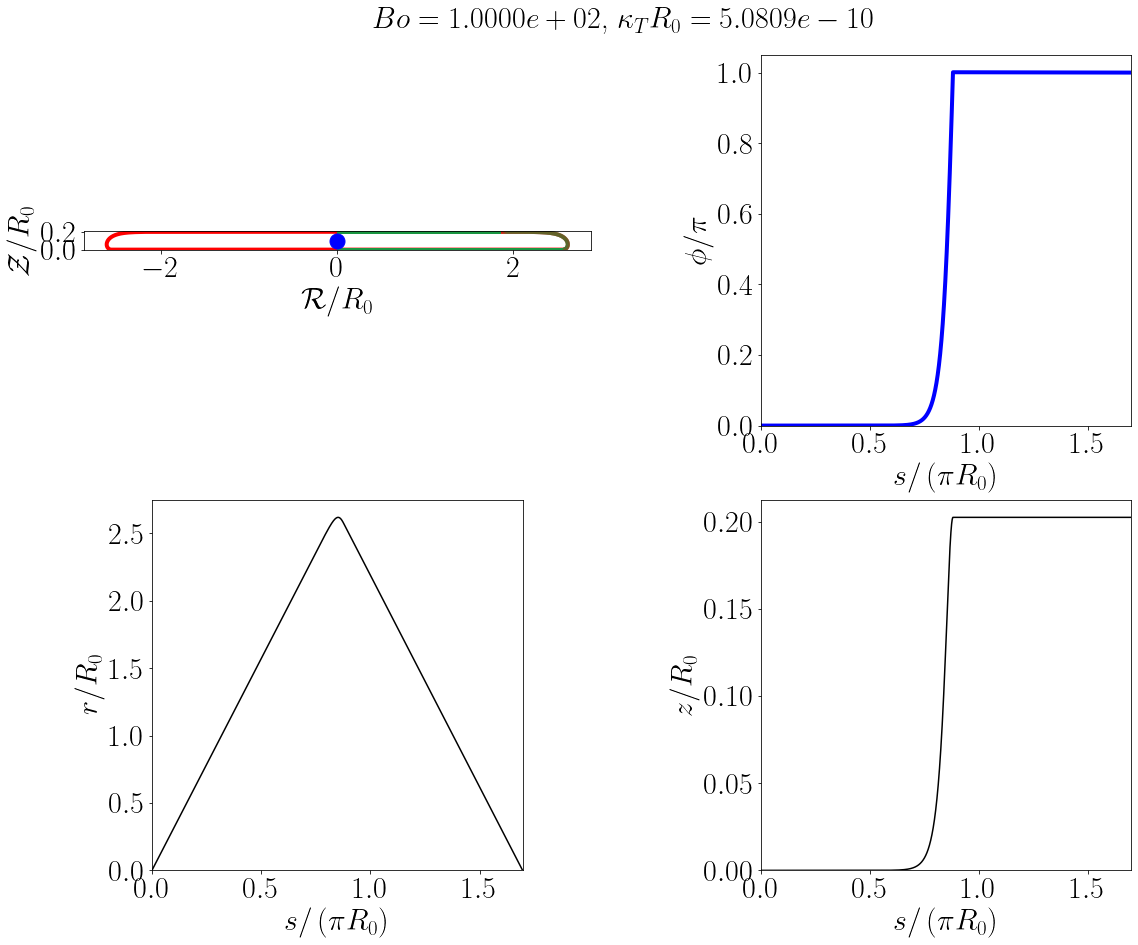

Initial guess for KappaT =  3.1928041543835893e-23
------------------------------------
Volume = 1.102e+00 and VolError = -3.087e+00
Done: Iteration = 1, Next KappaT = 7.2869e-24
------------------------------------
Volume = 1.152e+00 and VolError = -3.037e+00
Done: Iteration = 2, Next KappaT = 1.7544e-24
------------------------------------
Volume = 1.204e+00 and VolError = -2.985e+00
Done: Iteration = 3, Next KappaT = 4.4534e-25
------------------------------------
Volume = 1.259e+00 and VolError = -2.929e+00
Done: Iteration = 4, Next KappaT = 1.1920e-25
------------------------------------
Volume = 1.318e+00 and VolError = -2.870e+00
Done: Iteration = 5, Next KappaT = 3.3665e-26
------------------------------------
Volume = 1.382e+00 and VolError = -2.807e+00
Done: Iteration = 6, Next KappaT = 1.0044e-26
------------------------------------
Volume = 1.451e+00 and VolError = -2.738e+00
Done: Iteration = 7, Next KappaT = 3.1695e-27
------------------------------------
Volume = 1.543e+

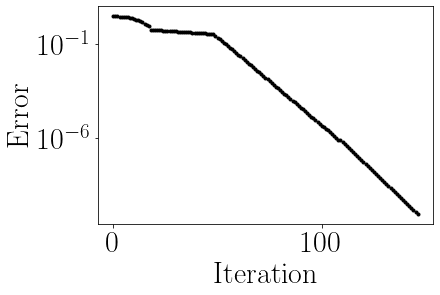

------------------------------------
(3V)(4pi)^{-1} = 1.0000e+00
Perimeter = 9.2358e+00
Surface Area = 1.3399e+02
KappaT = 4.8745e-32, Bo = 1.0000e+03, H = 0.063, Zcm = 0.032, W = 4.603, Rw = 4.586
<------------------------------------>
Doing Basilisk now for Bo = 1.0000e+03
Done with Basilisk for Bo = 1.0000e+03


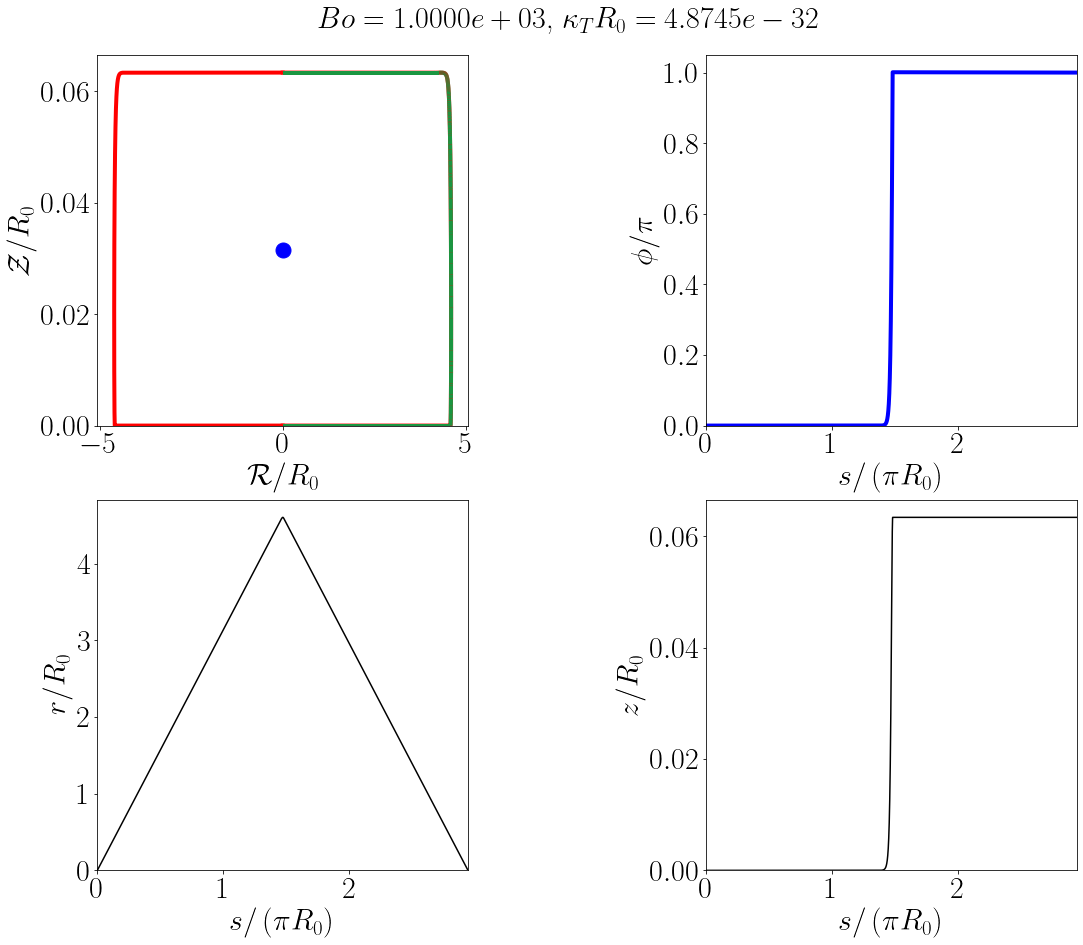

In [6]:
# Learning rate for the gradient descent algorithm and the maximum number of iterations, whether to plot the results, whether to plot error decay from the gradient descent, and the domain length for Basilisk code
lr, CountMax, Plot, PlotError, L0, TestWithBasilisk = 0.25, 500, True, True, 8.0, True
# TestWithBasilisk True needs a compiled Basilisk code in the same folder called InitialCondition.c. If you do not have this code, set TestWithBasilisk to False.

# Bond number is the input parameter. Use an array here to loop over multiple Bond numbers if needed. 
BondNumbers = array([1e-3, 1e-2, 1e-1, 1e0, 1e1, 1e2, 1e3])

KappaTlist = zeros_like(BondNumbers)
Bond = zeros_like(BondNumbers)
Height = zeros_like(BondNumbers)
Zcm = zeros_like(BondNumbers)
Width = zeros_like(BondNumbers)
Rfoot = zeros_like(BondNumbers)
Perimeter = zeros_like(BondNumbers)
SurfaceArea = zeros_like(BondNumbers)

folder='TestingImages'
if not os.path.exists(folder):
    os.makedirs(folder)
TableFile='NormalizeBond.csv'
if os.path.exists(TableFile):
   df = pd.read_csv(TableFile)
   Table=True
   # df.head()
else:
   KappaGuess = 2.0
   Table=False

for Bo in BondNumbers:
  if Table:
     # find the index of the closest value to the input value
     idx = (abs(df['Bond'] - Bo)).argmin()
     # print(idx)
     KappaT = df['KappaTR0'][idx]
  else:
      KappaT = KappaGuess
  
  print("Initial guess for KappaT = ", KappaT)

  R, Z, S, Phi, r, z, KappaT, Error = CorrectDrop(Bo, CountMax, lr, KappaT)

  if PlotError:
       plt.plot(abs(array(Error)), 'k.')
       plt.xlabel('Iteration')
       plt.ylabel('Error')
       plt.yscale('log')
       plt.show()
  # Save some metrics
  Rfoot[where(BondNumbers==Bo)] = R[-2]
  # width and height of the drop
  Height[where(BondNumbers==Bo)] = Z.max()
  Width[where(BondNumbers==Bo)] = R.max()
  # center of mass
  Zcm[where(BondNumbers==Bo)] = centerOfMass(R, Z)
  # Volume of the drop
  Vol = volume(R, Z)
  Vol /= (4.0/3.0)*pi        
  # Perimeter of the drop
  Perimeter[where(BondNumbers==Bo)] = S[-1]
  # Surface area of the drop
  SurfaceArea[where(BondNumbers==Bo)] = surface(R, Z, S)
  KappaTlist[where(BondNumbers==Bo)] = KappaT

  # Print some metrics!
  print('------------------------------------')
  print('(3V)(4pi)^{-1} = %5.4e' % Vol)
  print('Perimeter = %5.4e' % Perimeter[where(BondNumbers==Bo)])
  print('Surface Area = %5.4e' % SurfaceArea[where(BondNumbers==Bo)])

  print('KappaT = %5.4e, Bo = %5.4e, H = %4.3f, Zcm = %4.3f, W = %4.3f, Rw = %4.3f' % (KappaT, Bo, float(Height[where(BondNumbers==Bo)]), float(Zcm[where(BondNumbers==Bo)]), float(Width[where(BondNumbers==Bo)]), float(Rfoot[where(BondNumbers==Bo)])))
  print('<------------------------------------>')

  if TestWithBasilisk:
     print('Doing Basilisk now for Bo = %5.4e' % Bo)
     Interface = pd.DataFrame({'x': Z, 'y': R})
     InitConditionFile='%s/InitialCondition_Bo%4.3f.dat' % (folder, Bo)
     Interface.to_csv(InitConditionFile, index=False, header=False, sep=' ')
     # Run Basilisk
     InterfaceBas = gettingFacets(L0, InitConditionFile)
     print('Done with Basilisk for Bo = %5.4e' % Bo)
  else:
     InterfaceBas = None
     
  if Plot:
    filename = '%s/Drops_Bond_%5.4f.pdf' % (folder, Bo)
    Plotting(R, Z, S, Phi, r, z, filename, Bo, KappaT, Zcm[where(BondNumbers==Bo)], InterfaceBas, TestWithBasilisk)